In [2]:
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import lightgbm
import pandas as pd
import json

Lately I was learning Unity and gained an interest in Steam games, which prompted me to wonder about what makes a Steam game popular.

I found a Kaggle dataset online at https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data that has data about 97,000 Steam games! One of the feature of the dataset is "estimated_owners", i.e how many people own the game, which appear to be a good benchmark of how popular a game is. 

I've decided to explore and utilize the other features of the dataset (like the genre, the user score, the game description...) to train 4 different ML models in predicting estimated_owners.

Reference: In this project, I used a lot of code snippets from the lecture notes and assignment solution of UBC CPSC 330 Fall term 1 2024 course, particularly that of lecture 6, 8, 13, 14, assignment 5.

Thus, let us begin!

# Data Exploration

In [32]:
df = pd.read_json("data/games.json")
df = df.T
df.head()

,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,...,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags
20200,Galactic Bowling,"Oct 21, 2008",0,19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,6,11,0 - 20000,0,0,0,0,0,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,Train Bandit,"Oct 12, 2017",0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,53,5,0 - 20000,0,0,0,0,0,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."
1732930,Jolt Project,"Nov 17, 2021",0,4.99,0,Jolt Project: The army now has a new robotics ...,Jolt Project: The army now has a new robotics ...,"Shoot vehicles, blow enemies with a special at...",,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,0,0,0 - 20000,0,0,0,0,0,[]
1355720,Henosis™,"Jul 23, 2020",0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,3,0,0 - 20000,0,0,0,0,0,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su..."
1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.0,0,ABOUT THE GAME Play as a hacker who has arrang...,ABOUT THE GAME Play as a hacker who has arrang...,Two Weeks in Painland is a story-driven game a...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,50,8,0 - 20000,0,0,0,0,0,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '..."


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 97410 entries, 20200 to 3054200
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      97410 non-null  object
 1   release_date              97410 non-null  object
 2   required_age              97410 non-null  object
 3   price                     97410 non-null  object
 4   dlc_count                 97410 non-null  object
 5   detailed_description      97410 non-null  object
 6   about_the_game            97410 non-null  object
 7   short_description         97410 non-null  object
 8   reviews                   97410 non-null  object
 9   header_image              97410 non-null  object
 10  website                   97410 non-null  object
 11  support_url               97410 non-null  object
 12  support_email             97410 non-null  object
 13  windows                   97410 non-null  object
 14  mac                  

Currently, the data type of every column is set to 'object.' However, certain columns, such as 'name,' are better suited to a string data type, while others, like 'user_score,' are more appropriately represented as integers. Therefore, I will adjust the data types as outlined below:

In [12]:
df = df.infer_objects()

In [13]:
df['name'] = df['name'].astype('string')
df['detailed_description'] = df['detailed_description'].astype('string')
df['about_the_game'] = df['about_the_game'].astype('string')
df['short_description'] = df['short_description'].astype('string')

In [14]:
print(df.dtypes)

name                        string[python]
release_date                        object
required_age                         int64
price                              float64
dlc_count                            int64
detailed_description        string[python]
about_the_game              string[python]
short_description           string[python]
reviews                             object
header_image                        object
website                             object
support_url                         object
support_email                       object
windows                               bool
mac                                   bool
linux                                 bool
metacritic_score                     int64
metacritic_url                      object
achievements                         int64
recommendations                      int64
notes                               object
supported_languages                 object
full_audio_languages                object
packages   

Next, I'll create test-training split, and make sure the model is trained on training set only, with no information from test set leaking in.

In [15]:
X= df.drop(columns=["estimated_owners"])
y = df["estimated_owners"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68187, 40)
(29223, 40)
(68187,)
(29223,)


Next, I created a couple of new columns related to release date, day_of_week, month, year, etc. 
This is actually done during the Feature Engineering step, but I moved the code up here, so I can to visualize these columns in graphs and plots along with the original features.

I debated whether features like "day_of_week" be a numerical, or categorical data. There seems to be an inherent order to 
it, like Monday is closer to Tuesday than to Friday, which can be captured if the feature is numeric. However, I intend to 
use a linear classification model later on, and linear models cannot detect any cyclical patterns in the data. After debating, I decided to make "day_of_week" categorical. 

I also represented 'day_of_month' as a categorical column. However, there are 31 different possible values for the column, which seems to be a lot. So I decided to group them into 6 bins: day 1-5, 5-10, 10-15, 15-20, 20-25, 25-31. 

In [16]:
def process_release_date(df):
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    
    df['day_of_week'] = df['release_date'].dt.weekday
    df['month'] = df['release_date'].dt.month
    df['year'] = df['release_date'].dt.year
    df['day_of_month'] = df['release_date'].dt.day
    df['quarter'] = df['release_date'].dt.quarter
    
    bins = [0, 5, 10, 15, 20, 25, 31]
    labels = [0, 1, 2, 3, 4, 5]
    df['day_of_month_category'] = pd.cut(df['day_of_month'], bins=bins, labels=labels, right=True)
    
    df['day_of_week'] = df['day_of_week'].fillna(df['day_of_week'].mode()[0])
    df['month'] = df['month'].fillna(df['month'].mode()[0])
    df['year'] = df['year'].fillna(df['year'].mode()[0])
    df['day_of_month_category'] = df['day_of_month_category'].fillna(df['day_of_month_category'].mode()[0])
    df['quarter'] = df['quarter'].fillna(df['quarter'].mode()[0])
    
    return df

# Apply the function to both datasets
X_train = process_release_date(X_train)
X_test = process_release_date(X_test)


In [12]:
X_train['day_of_month_category'][0:10]

1140930    5
1410710    2
2312510    4
622870     3
2274970    4
782460     5
1482230    4
1453640    5
2409750    5
2655130    3
Name: day_of_month_category, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

Now, I want to get an overview of the numerical features:

In [18]:
print(X_train[["required_age", "price", "average_playtime_forever", "median_playtime_forever", "achievements", "user_score"]].describe())

       required_age         price  average_playtime_forever  \
count  68187.000000  68187.000000              68187.000000   
mean       0.284556      7.084474                 91.457829   
std        2.148103     12.336483               1106.464246   
min        0.000000      0.000000                  0.000000   
25%        0.000000      0.990000                  0.000000   
50%        0.000000      4.190000                  0.000000   
75%        0.000000      9.990000                  0.000000   
max       21.000000    999.980000             145727.000000   

       median_playtime_forever  achievements    user_score  
count             68187.000000  68187.000000  68187.000000  
mean                 80.302330     18.532668      0.029375  
std                1438.172696    160.364009      1.544214  
min                   0.000000      0.000000      0.000000  
25%                   0.000000      0.000000      0.000000  
50%                   0.000000      0.000000      0.000000  
75%  

Get an overview of the categorical feature as well: 

In [21]:
print(X_train[["windows", "mac", "linux"]].describe())

       windows    mac  linux
count    68187  68187  68187
unique       2      2      2
top       True  False  False
freq     68166  55860  59549


Get an overview of the target feature:

In [15]:
print(
    "estimated_owners:\n",
    y_train.value_counts(normalize=True),
)

estimated_owners:
 estimated_owners
0 - 20000               0.630971
0 - 0                   0.176632
20000 - 50000           0.081892
50000 - 100000          0.040682
100000 - 200000         0.027029
200000 - 500000         0.022893
500000 - 1000000        0.009430
1000000 - 2000000       0.005426
2000000 - 5000000       0.003402
5000000 - 10000000      0.000939
10000000 - 20000000     0.000396
20000000 - 50000000     0.000264
50000000 - 100000000    0.000044
Name: proportion, dtype: float64


There is clear class imbalance. In this case, accuracy won't be a good evaluator of a model's performance (since even the 
Dummy Classifier can do relatively well, if it just predict the most popular class). 

Therefore, I decided to use multi-class f1 macro score instead. This metric is particularly suitable, because it calculates the F1 score for each class individually and then averages them, treating each class with equal importance.

In [23]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer_macro = make_scorer(f1_score, average="macro")
# code inspired by UBC CPSC 330 2024 Fall hw 5 solution

Update: this is a step I added after going through preprocessing, training, and predicting once. 

I found that all 4 of my models have very low test scores (around 0.2), after printing out the f1 score for each class, I saw the classes that have a lot of training data (like class "0-20000") have high f1 scores while the class that have very little training data (like "50000000 - 100000000") have low scores. 

Since many classes suffer from insufficient data, I decided to create broader bins for the estimated_owners feature. The new bins are: '0-0,' '0-20000,' '20000-1000000,' and '1000000-200000000.' These bins provide a more balanced distribution of data across classes, and they remain insightful in categorizing the popularity of Steam games.

In [24]:
mapping = {
    "0 - 20000": "0 - 20000",
    "0 - 0": "0 - 0",
    "20000 - 50000": "20000 - 1000000",
    "50000 - 100000": "20000 - 1000000",
    "100000 - 200000": "20000 - 1000000",
    "200000 - 500000": "20000 - 1000000",
    "500000 - 1000000": "20000 - 1000000",
    "1000000 - 2000000": "1000000 - 200000000",
    "2000000 - 5000000": "1000000 - 200000000",
    "5000000 - 10000000": "1000000 - 200000000",
    "10000000 - 20000000": "1000000 - 200000000",
    "20000000 - 50000000": "1000000 - 200000000",
    "50000000 - 100000000": "1000000 - 200000000",
    "100000000 - 200000000": "1000000 - 200000000"
}
y_train = y_train.map(mapping)
y_test = y_test.map(mapping)
print(
    "estimated_owners:\n",
    y_train.value_counts(),
)
print(
    "estimated_owners:\n",
    y_test.value_counts(),
)

estimated_owners:
 estimated_owners
0 - 20000              43051
20000 - 1000000        12234
0 - 0                  12185
1000000 - 200000000      717
Name: count, dtype: int64
estimated_owners:
 estimated_owners
0 - 20000              18382
20000 - 1000000         5470
0 - 0                   5078
1000000 - 200000000      293
Name: count, dtype: int64


# Data Exploration - Plots and Graphs

In [25]:
numerical_columns_X_train = X_train.select_dtypes(include=["int", "float"])

In [28]:
print(numerical_columns_X_train.shape)  
print(numerical_columns_X_train.columns) 

(68187, 19)
Index(['required_age', 'price', 'dlc_count', 'metacritic_score',
       'achievements', 'recommendations', 'user_score', 'positive', 'negative',
       'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu',
       'day_of_week', 'month', 'year', 'day_of_month', 'quarter'],
      dtype='object')


array([[<Axes: title={'center': 'required_age'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'dlc_count'}>,
        <Axes: title={'center': 'metacritic_score'}>],
       [<Axes: title={'center': 'achievements'}>,
        <Axes: title={'center': 'recommendations'}>,
        <Axes: title={'center': 'user_score'}>,
        <Axes: title={'center': 'positive'}>],
       [<Axes: title={'center': 'negative'}>,
        <Axes: title={'center': 'average_playtime_forever'}>,
        <Axes: title={'center': 'average_playtime_2weeks'}>,
        <Axes: title={'center': 'median_playtime_forever'}>],
       [<Axes: title={'center': 'median_playtime_2weeks'}>,
        <Axes: title={'center': 'peak_ccu'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'day_of_month'}>,
        <Axes: title={'center': 'quarter'}>, <Axes: >]], dtype=object)

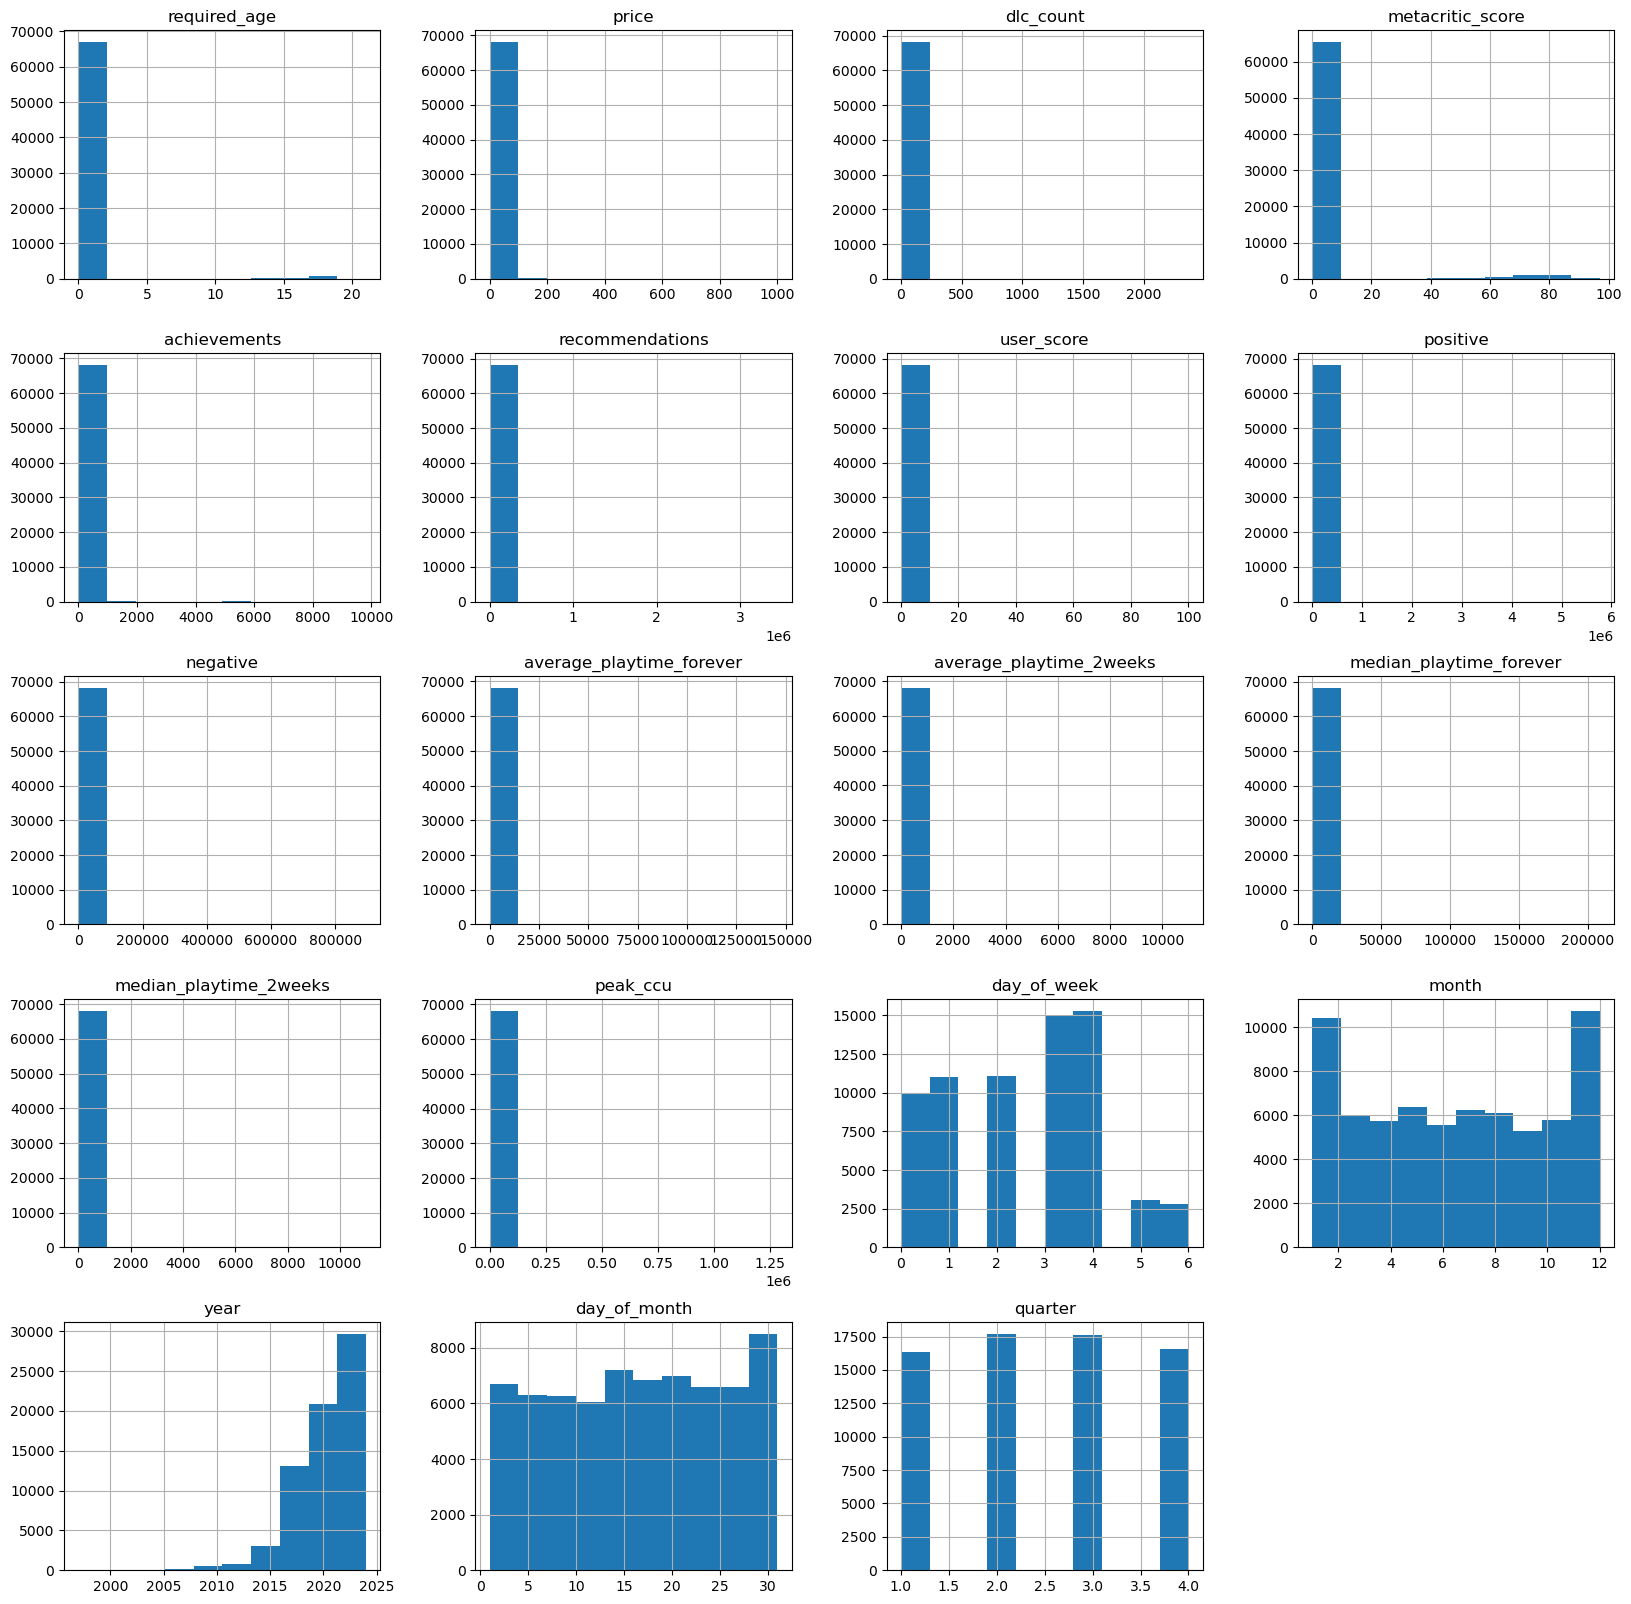

In [29]:
numerical_columns_X_train.hist(figsize=(20, 20), bins=10)
# code inspired by UBC CPSC 330 2024 Fall hw 5 solution

The bar graph shows that many features are quite skewed. It seems the vast majority of games have 0 user score, 0 achievements, 0 positive reviews, 0 negative reviews...

I also created 3 different versions of box plots. 

Version 1, using the original data: because many features are skewed and have a lot of values concentrated around 0, the whisker box become so narrow, it appear like a vertical line. 

Version 2, using the non-zero data: I want to get an overview of the non-zero data which are obscured in version 1 of my boxplots. The plots are more insightful than version 1 for features like "metacritic_score", showing that non-zero scores cluster around the 70s. 

Version 3, using log transformation on the data: There are some insightful information in price feature, showing that prices between 10 and 100 dollars are most popular. 

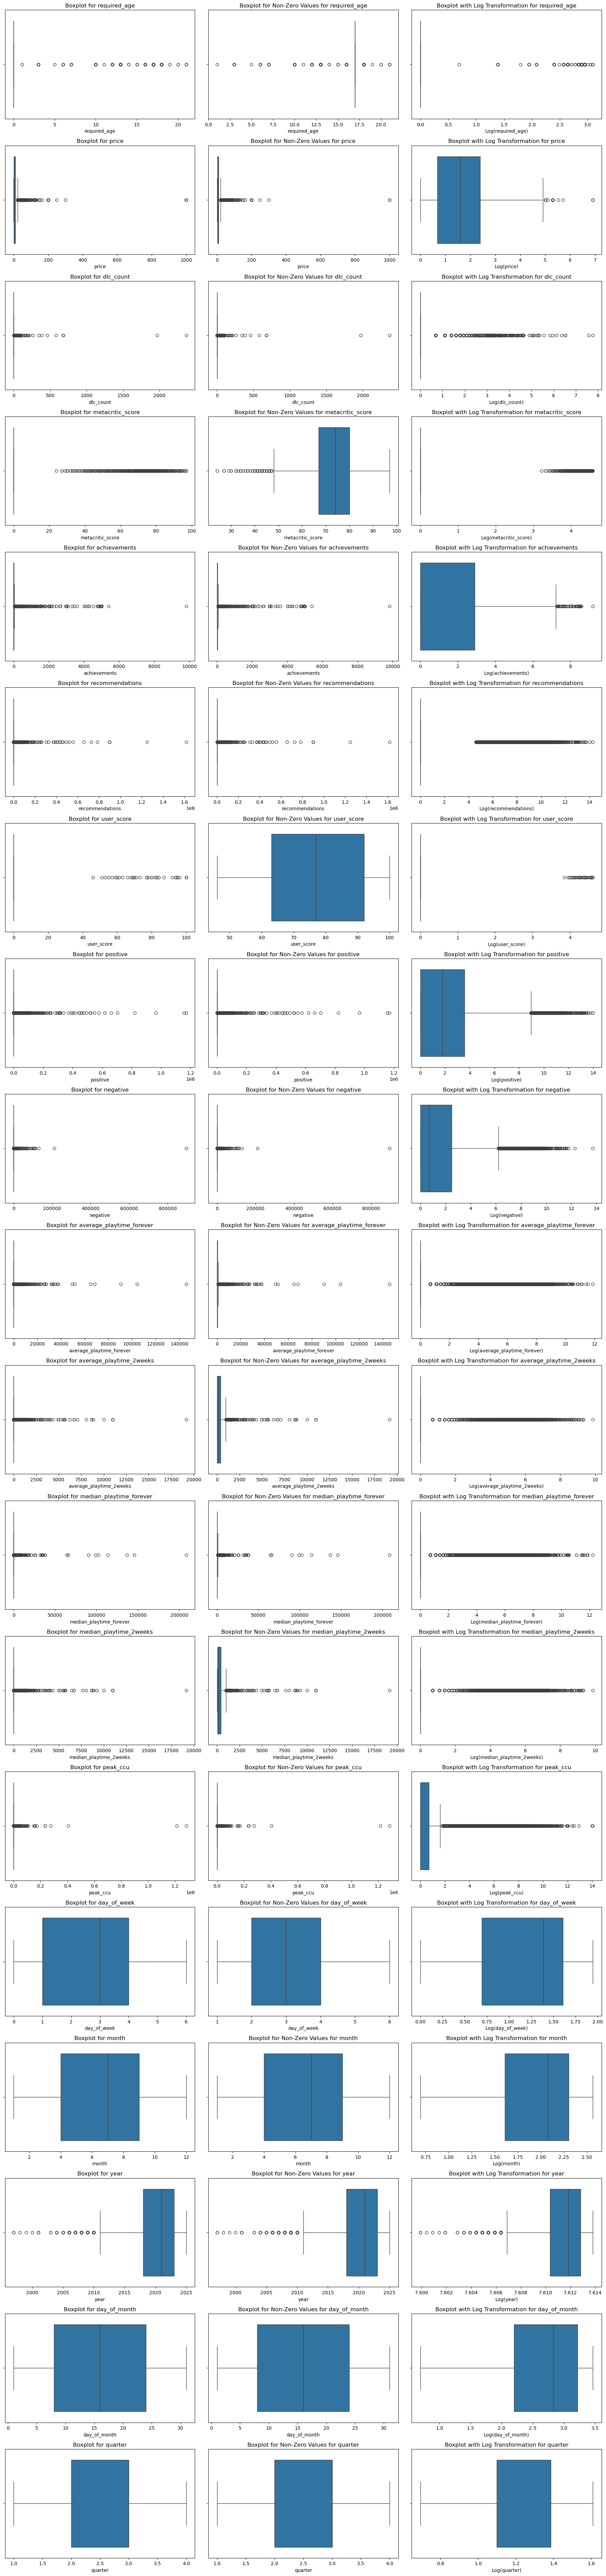

In [24]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

log_df = np.log1p(numerical_columns_X_train) 

num_columns = 3  
num_features = len(numerical_columns_X_train.columns)
num_rows = (num_features * 3 + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 4))
axes = axes.flatten() 

plot_idx = 0  

for column in numerical_columns_X_train.columns:
    # Original Boxplot
    sns.boxplot(data=numerical_columns_X_train, x=column, ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Boxplot for {column}')
    axes[plot_idx].set_xlabel(column)
    plot_idx += 1

    # Boxplot for Non-Zero Values
    non_zero_data = numerical_columns_X_train[numerical_columns_X_train[column] != 0]
    sns.boxplot(data=non_zero_data, x=column, ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Boxplot for Non-Zero Values for {column}')
    axes[plot_idx].set_xlabel(column)
    plot_idx += 1

    # Boxplot with Log Transformation
    sns.boxplot(data=log_df, x=column, ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Boxplot with Log Transformation for {column}')
    axes[plot_idx].set_xlabel(f'Log({column})')
    plot_idx += 1

for ax in axes[plot_idx:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Finally, I created dot plots to better visualize the distribution of the numerical features. Compared to bar graphs, dot plots provide a clearer representation of the data's distribution and clustering. In some bar graphs, certain bars were disproportionately higher than others, overshadowing the rest, obscuring the overall distribution of the remaining values.

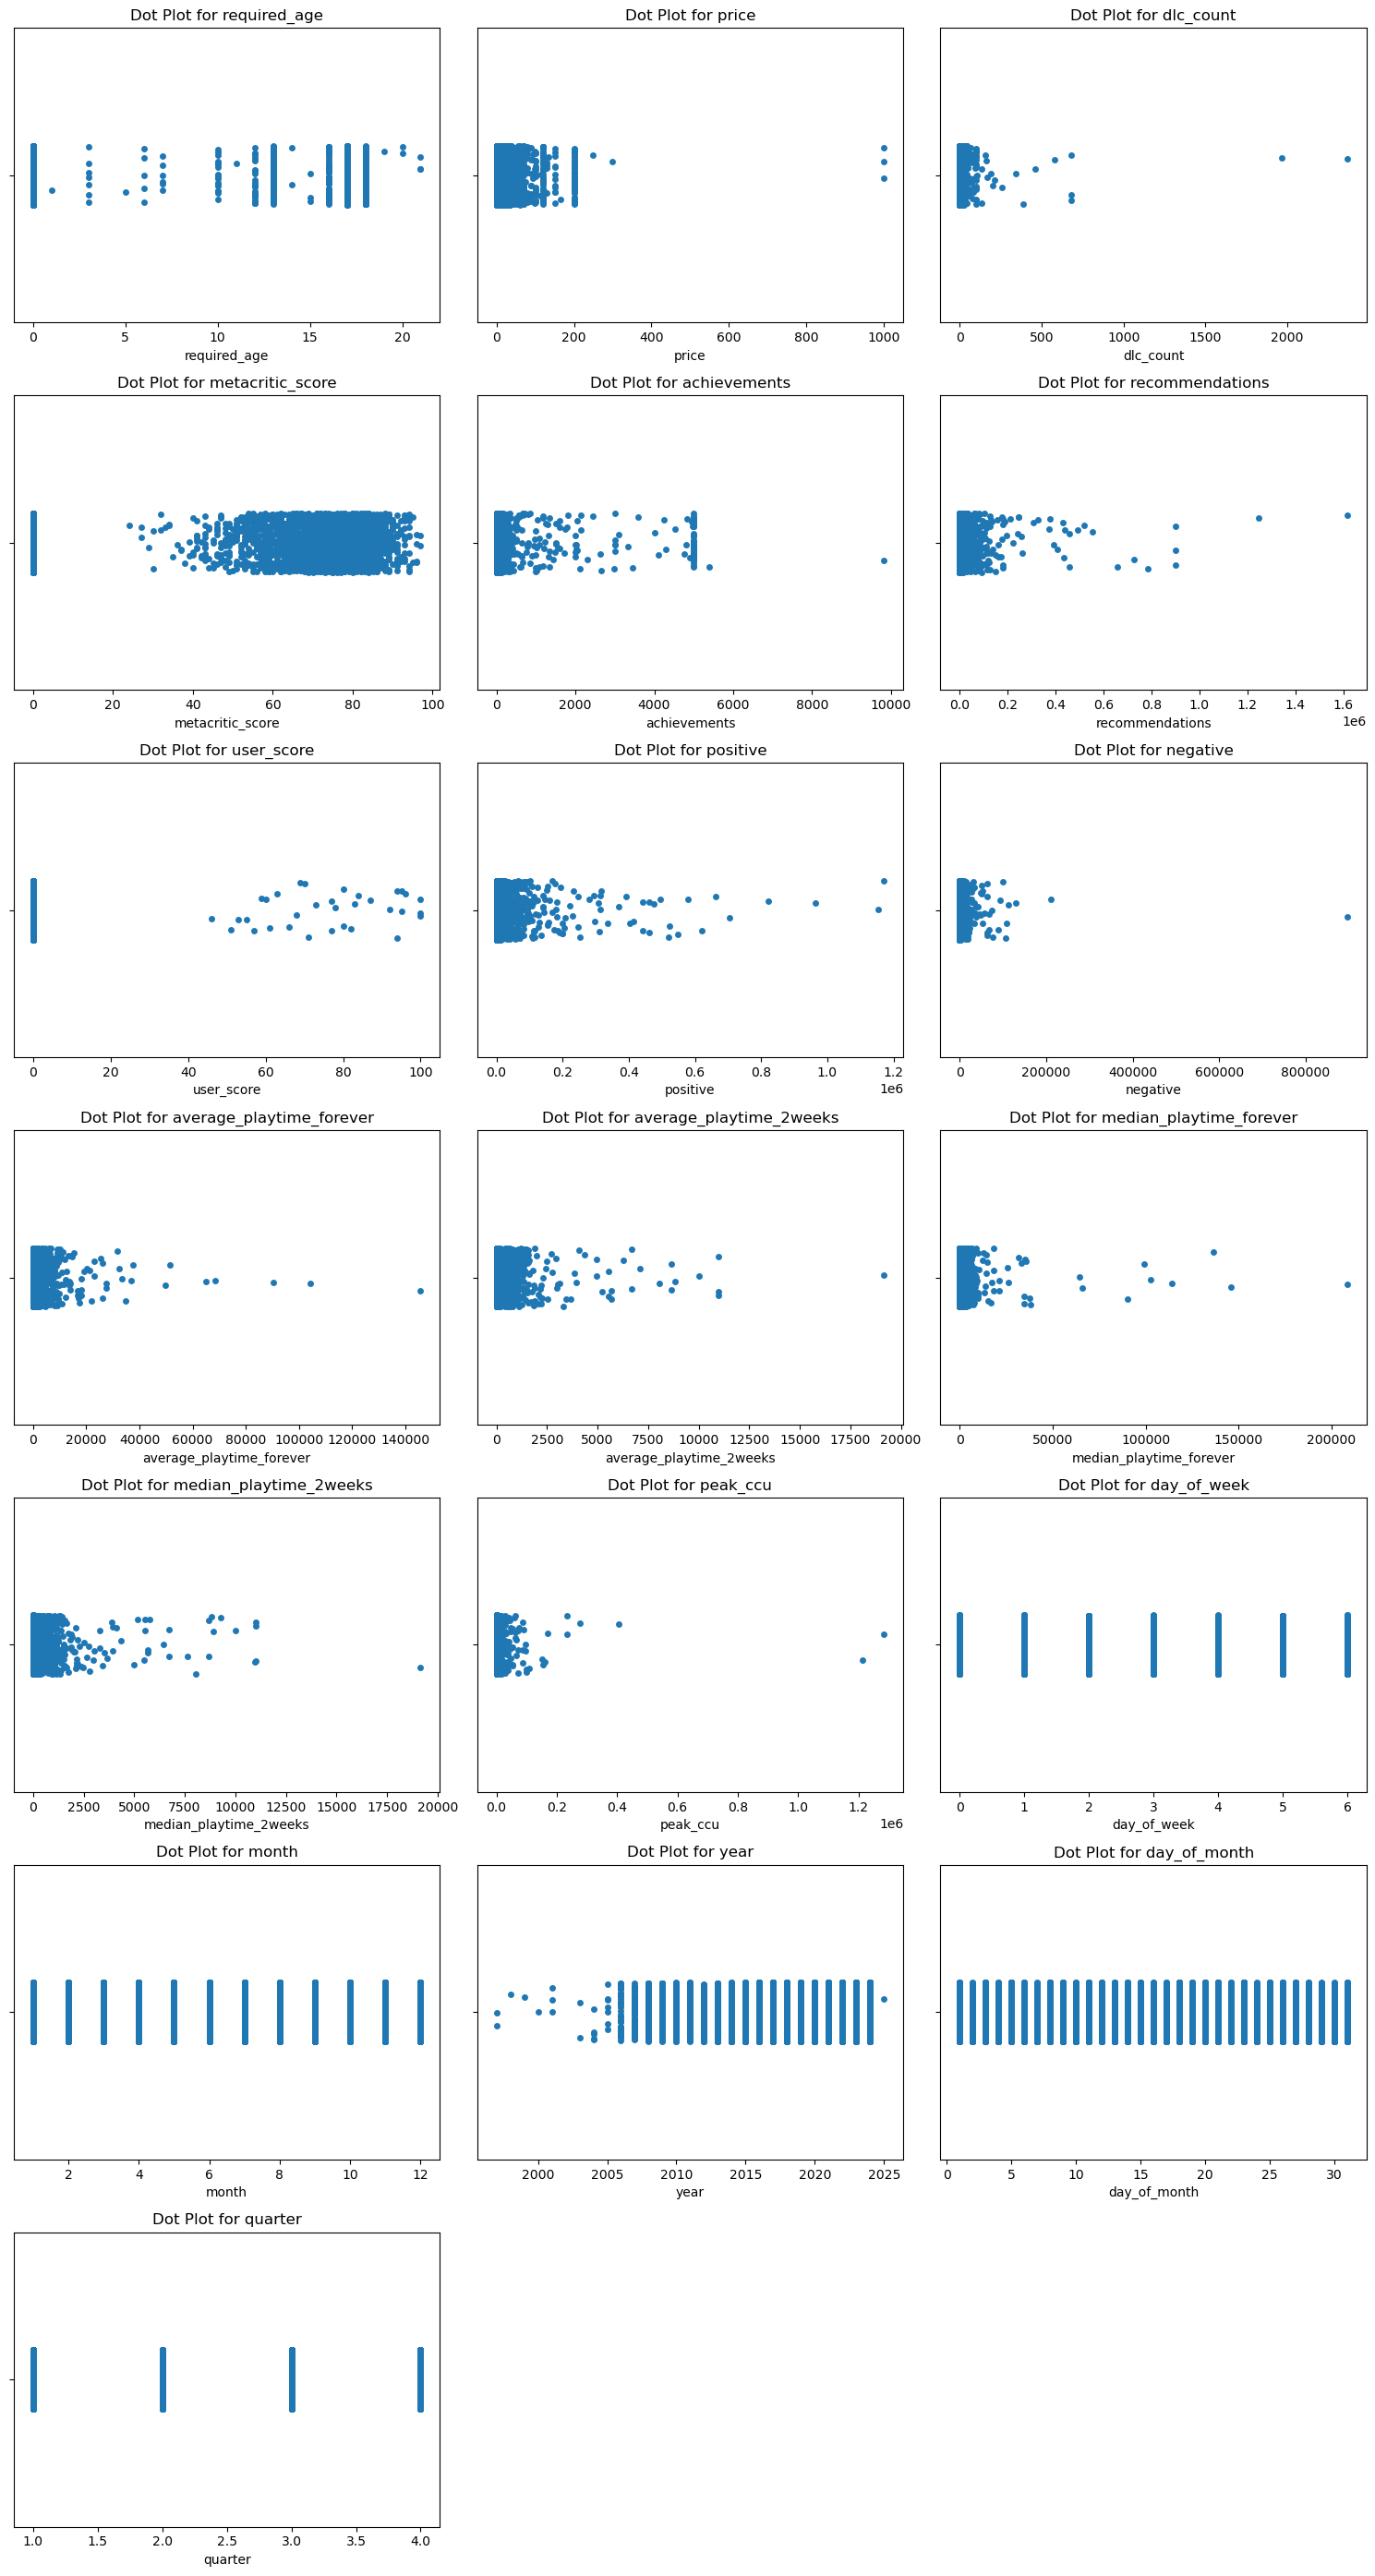

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = numerical_columns_X_train.columns
n_cols = 3  
n_rows = (len(columns) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))  
axes = axes.flatten()  

for i, column in enumerate(columns):
    sns.stripplot(data=numerical_columns_X_train, x=column, jitter=True, ax=axes[i])  
    axes[i].set_title(f'Dot Plot for {column}')
    axes[i].set_xlabel(column)

for i in range(len(columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()  
plt.show()

# Feature Engineering

I created a joint plot to explore the potential correlation between positive reviews and negative reviews

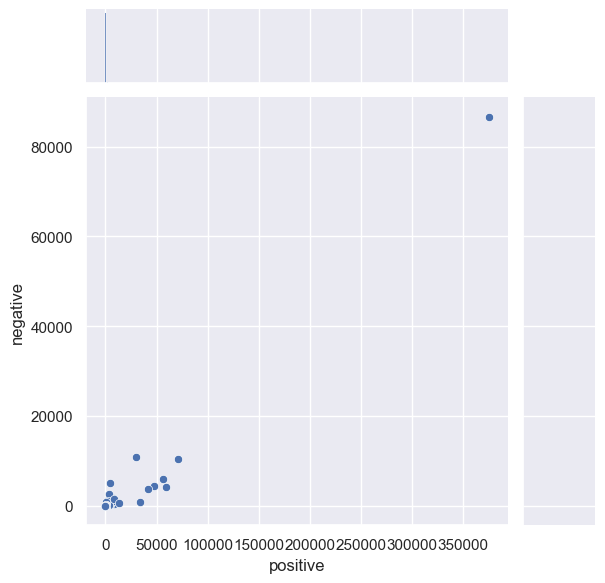

In [35]:
df_samples = df.sample(n=1000, random_state=42)
sns.jointplot(x="positive", y="negative", data=df_samples)
# code inspired by UBC CPSC 330 2024 Fall hw 5 solution

I identified a potential issue with using the number of positive and negative reviews as predictors for estimating estimated_owners, as this could lead to data leakage. Naturally, games with more owners are likely to have more reviews. 

Therefore, I created a new feature, positive_rate, representing the proportion of positive reviews relative to the total. However, I recognized that when the total number of reviews is very low — such as a single positive review — the positive rate becomes unreliable. 

To address this, I created a constraint, assigning a non-NaN value to positive_rate only when the total number of reviews exceeds 10.

In [36]:
import numpy as np

denominator = (X_train["negative"] + X_train["positive"]).where(
    ((X_train["negative"] + X_train["positive"]) != 0) & ((X_train["negative"] + X_train["positive"]) >= 10), np.nan
)
X_train["positive_rate"] = X_train["positive"] / denominator

denominator = (X_test["negative"] + X_test["positive"]).where(
    ((X_test["negative"] + X_test["positive"]) != 0) & ((X_test["negative"] + X_test["positive"]) >= 10), np.nan
)
X_test["positive_rate"] = X_test["positive"] / denominator

# Data Preprocessing

With feature engineering complete and new features created, I proceeded to design a data preprocessing pipeline tailored to different types of features. This pipeline addresses various feature categories, including numerical, passthrough, multi-label, categorical, etc.

After some consideration, I decided to exclude certain features from the dataset for two reasons.

First, the Steam Game dataset contains 40 features, which is a large number for a small-scale project and could introduce unnecessary complexity. 

Second, some features are not as useful in the target variable. For instance, while a polished website can help promote a game and increase its popularity, the URL itself is not very informative for prediction. Extracting meaningful insights from those links is challenging and don't justify the added complexity in the model

In [37]:
numerical_feats = ["required_age", "price", "metacritic_score", "average_playtime_forever", "median_playtime_forever",  "achievements", "user_score", "recommendations"]
passthrough_feats = ["windows", "mac", "linux"]
multi_label_feats = ["supported_languages", "full_audio_languages", "genres", "categories", "tags"]
categorical_feats = ["day_of_week", "month", "year", "day_of_month_category", "quarter"]
drop_feats = ["dlc_count", "reviews", "header_image", "website", "support_url", "support_email", "metacritic_url", "notes", "packages", "developers", "publishers", "screenshots", "movies", "score_rank", "positive", "negative", "average_playtime_2weeks", "median_playtime_2weeks", "peak_ccu"]
textual_feat_1 = "name"
textual_feat_2 = "detailed_description"
textual_feat_3 = "about_the_game"
textual_feat_4 = "short_description"
# code partly inspired by UBC CPSC 330 2024 Fall lecture 5, 6

In [38]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X_train, y=None):
        self.mlb.fit(X_train)
        return self

    def transform(self, X_train):
        return self.mlb.transform(X_train)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_  

ct_1 = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numerical_feats,
    ),  # scaling on numeric features
    (OneHotEncoder(handle_unknown='ignore'), categorical_feats),
    (MultiLabelBinarizerTransformer(), "genres"), 
    (MultiLabelBinarizerTransformer(), "tags"),
    (MultiLabelBinarizerTransformer(), "supported_languages"),
    (MultiLabelBinarizerTransformer(), "full_audio_languages"),
    (MultiLabelBinarizerTransformer(), "categories"),
    (CountVectorizer(max_features=50, stop_words="english"), textual_feat_1),
    (CountVectorizer(max_features=50, stop_words="english"), textual_feat_2),
    (CountVectorizer(max_features=50, stop_words="english"), textual_feat_3),
    (CountVectorizer(max_features=50, stop_words="english"), textual_feat_4),
    ("passthrough", passthrough_feats),  
    ("drop", drop_feats) 
)
# code partly inspired by UBC CPSC 330 2024 Fall lecture 5, 6

In [39]:
transformed = ct_1.fit_transform(X_train[0:20])

In [40]:
ct_1.named_transformers_

{'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 'onehotencoder': OneHotEncoder(handle_unknown='ignore'),
 'multilabelbinarizertransformer-1': MultiLabelBinarizerTransformer(),
 'multilabelbinarizertransformer-2': MultiLabelBinarizerTransformer(),
 'multilabelbinarizertransformer-3': MultiLabelBinarizerTransformer(),
 'multilabelbinarizertransformer-4': MultiLabelBinarizerTransformer(),
 'multilabelbinarizertransformer-5': MultiLabelBinarizerTransformer(),
 'countvectorizer-1': CountVectorizer(max_features=50, stop_words='english'),
 'countvectorizer-2': CountVectorizer(max_features=50, stop_words='english'),
 'countvectorizer-3': CountVectorizer(max_features=50, stop_words='english'),
 'countvectorizer-4': CountVectorizer(max_features=50, stop_words='english'),
 'passthrough': FunctionTransformer(accept_sparse=True, check_inverse=False,
                     feature_names_out='one-to-one'),
 'drop': 'drop',
 'rem

In [41]:
column_names = (
    numerical_feats
    + ct_1.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["multilabelbinarizertransformer-1"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["multilabelbinarizertransformer-2"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["multilabelbinarizertransformer-3"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["multilabelbinarizertransformer-4"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["multilabelbinarizertransformer-5"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["countvectorizer-1"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["countvectorizer-2"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["countvectorizer-3"].get_feature_names_out().tolist()
    + ct_1.named_transformers_["countvectorizer-4"].get_feature_names_out().tolist()
    + passthrough_feats    
)
print(column_names)
# code partly inspired by UBC CPSC 330 2024 Fall lecture 5, 6

['required_age', 'price', 'metacritic_score', 'average_playtime_forever', 'median_playtime_forever', 'achievements', 'user_score', 'recommendations', 'day_of_week_0.0', 'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_6.0', 'month_1.0', 'month_4.0', 'month_5.0', 'month_7.0', 'month_9.0', 'month_10.0', 'month_12.0', 'year_2016.0', 'year_2017.0', 'year_2018.0', 'year_2019.0', 'year_2020.0', 'year_2021.0', 'year_2022.0', 'year_2023.0', 'year_2024.0', 'day_of_month_category_0', 'day_of_month_category_1', 'day_of_month_category_2', 'day_of_month_category_3', 'day_of_month_category_4', 'day_of_month_category_5', 'quarter_1.0', 'quarter_2.0', 'quarter_3.0', 'quarter_4.0', 'Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Early Access', 'Free to Play', 'Indie', 'RPG', 'Simulation', 'Strategy', '1980s', "1990's", '2D', '3D', 'Action', 'Action RPG', 'Action-Adventure', 'Addictive', 'Adventure', 'Anime', 'Arcade', 'Atmospheric', 'Beautiful', 'Board 

In [33]:
pd.set_option('display.max_columns', 25)
print(pd.DataFrame(transformed, columns=column_names))

    required_age     price  metacritic_score  average_playtime_forever  \
0            0.0 -0.425400               0.0                 -0.412984   
1            0.0  0.439200               0.0                  1.721992   
2            0.0  3.531805               0.0                 -0.412984   
3            0.0 -0.092861               0.0                  2.869541   
4            0.0 -0.325638               0.0                 -0.412984   
5            0.0 -0.458321               0.0                 -0.412984   
6            0.0 -0.458321               0.0                 -0.412984   
7            0.0 -0.059607               0.0                 -0.412984   
8            0.0 -0.458321               0.0                 -0.412984   
9            0.0 -0.365543               0.0                 -0.412984   
10           0.0 -0.392146               0.0                 -0.412984   
11           0.0  2.201652               0.0                 -0.412984   
12           0.0 -0.458321            

The pipeline appear to be working properly, so I'll move on to training different models.

# Baseline Model: Dummy Classifier

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [46]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="stratified")
scores_accuracy = cross_validate(dummy, X_train, y_train_encoded, return_train_score=True)
scores_f1_macro = cross_validate(dummy, X_train, y_train_encoded, return_train_score=True, scoring=custom_scorer_macro)
print(scores_accuracy)
print(scores_f1_macro)

{'fit_time': array([0.05102706, 0.04056287, 0.02929688, 0.02545404, 0.02621007]), 'score_time': array([0.001652  , 0.00099421, 0.00093102, 0.00108099, 0.00098896]), 'test_score': array([0.46275114, 0.46553747, 0.45999853, 0.46168512, 0.45999853]), 'train_score': array([0.45986178, 0.46380319, 0.46452796, 0.46456462, 0.46223648])}
{'fit_time': array([0.02571702, 0.0282259 , 0.02557421, 0.02473021, 0.02458215]), 'score_time': array([0.00297809, 0.00278497, 0.00296974, 0.003124  , 0.00255919]), 'test_score': array([0.24498435, 0.24776391, 0.24738159, 0.25276211, 0.24154677]), 'train_score': array([0.25006746, 0.25083876, 0.2485456 , 0.25066921, 0.24876176])}


The DummyClassifier achieved test scores of approximately 0.25, which is exactly the probability of correctly predicting a category through random selection, since the target variable has exactly 4 possible categories.

# Model 1: Decision Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier
lr = DecisionTreeClassifier()
pipe_1 = make_pipeline(ct_1,select_rf, lr)
pipe_2 = make_pipeline(ct_1, lr)
scores = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
scores_with_feat_selection = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
print(pd.DataFrame(scores))
print(pd.DataFrame(scores_with_feat_selection))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Movie'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['\r\nFrench', '\r\nGerman', 'German;', 'Hungarian,Polish', 'Spanish - Spain\r\n[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Spanish - Spain\r\n[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English,German,Spanish - Spain,#lang_français', 'Japanese (all with full audio support)'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [' Korean', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(
/opt/

    fit_time  score_time  test_score  train_score
0  19.665215    1.340566    0.727854     0.999983
1  20.430517    1.346431    0.733790     0.999983
2  20.198870    1.305838    0.751936     0.999967
3  20.147835    1.352380    0.745231     0.999983
4  20.586701    1.348043    0.723720     0.999967
    fit_time  score_time  test_score  train_score
0  19.745688    1.353029    0.729682     0.999983
1  21.059856    1.336402    0.732990     0.999983
2  20.873290    1.332262    0.755396     0.999967
3  20.278942    1.355644    0.736199     0.999983
4  20.552160    1.340668    0.725991     0.999967


# Decision Tree - Hyperparameter optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# n_estimators, max_depth, max_features
import warnings

warnings.filterwarnings("ignore")
param_grid = {
    "decisiontree_max_depth": [1,10,100,1000,10000,100000]
    "decisiontree_min_samples_split": [5,10,50,100,500,1000,2000,5000],
    "decisiontree_min_samples_leaf": [5,10,50,100,500,1000],
    "decisiontree_max_leaf_nodes": [5,10,50,100,500,1000],    
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
print(param_grid)

# Create a random search object
random_search = RandomizedSearchCV(pipe_feat_selection,                                    
                  param_distributions = param_grid, 
                  n_iter=50, 
                  n_jobs=-1, 
                  return_train_score=True,
                scoring=custom_scorer_macro)

# Carry out the search
random_search.fit(X_train[0:5000], y_train_encoded[0:5000])
# code partly inspired by UBC CPSC 330 2024 Fall lecture 8

    fit_time  score_time  test_score  train_score
    
0  19.665215    1.340566    0.727854     0.999983

1  20.430517    1.346431    0.733790     0.999983

2  20.198870    1.305838    0.751936     0.999967

3  20.147835    1.352380    0.745231     0.999983

4  20.586701    1.348043    0.723720     0.999967

    fit_time  score_time  test_score  train_score
    
0  19.745688    1.353029    0.729682     0.999983

1  21.059856    1.336402    0.732990     0.999983

2  20.873290    1.332262    0.755396     0.999967

3  20.278942    1.355644    0.736199     0.999983

4  20.552160    1.340668    0.725991     0.999967

There is no major difference with / without feature selection.

# Model 2 - Random Forest

I decide to compare the performance of the Random Forest model with and without feature selection.

In [43]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier 
select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    threshold="median"
)

In [47]:
from sklearn.ensemble import RandomForestClassifier
pipe = make_pipeline(ct_1, RandomForestClassifier())
pipe_feat_selection = make_pipeline(ct_1, select_rf, RandomForestClassifier())
scores_macro = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
scores_macro_feat_selection = cross_validate(pipe_feat_selection, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
print(pd.DataFrame(scores_macro))
print(pd.DataFrame(scores_macro_feat_selection))

    fit_time  score_time  test_score  train_score
0  16.912272    1.524789    0.679964     0.999983
1  16.888676    1.502557    0.696232     0.999983
2  17.300197    1.548108    0.704478     0.999967
3  17.032368    1.527410    0.695136     0.999967
4  17.293969    1.510416    0.684144     0.999967
    fit_time  score_time  test_score  train_score
0  27.570183    1.521062    0.715844     0.999983
1  27.624279    1.522291    0.715635     0.999983
2  28.228182    1.524731    0.725059     0.999967
3  27.516082    1.555029    0.722161     0.999735
4  28.397100    1.541484    0.687917     0.999967


It appears that with feature selection, the test scores are higher.

# Random Forest - Hyperparameter Optimization

During the randomized search process, I opted to use only a subsample of the training data to speedup the process. However, with more time, I'll come back and rerun it on the whole dataset for a better result.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
# n_estimators, max_depth, max_features
import warnings

warnings.filterwarnings("ignore")
param_grid = {
    "randomforestclassifier__n_estimators": [1, 2, 4, 6, 8, 10],
    "randomforestclassifier__max_depth": [5,10,50,100,250,500],
    "randomforestclassifier__max_features": [1,2,4,6,8,10,15,20,30],
}

print("Grid size: %d" % (np.prod(list(map(len, param_grid.values())))))
print(param_grid)

# Create a random search object
random_search = RandomizedSearchCV(pipe_feat_selection,                                    
                  param_distributions = param_grid, 
                  n_iter=50, 
                  n_jobs=-1, 
                  return_train_score=True,
                scoring=custom_scorer_macro)

# Carry out the search
random_search.fit(X_train[0:1000], y_train_encoded[0:1000])
# code partly inspired by UBC CPSC 330 2024 Fall lecture 8

Grid size: 324
{'randomforestclassifier__n_estimators': [1, 2, 4, 6, 8, 10], 'randomforestclassifier__max_depth': [5, 10, 50, 100, 250, 500], 'randomforestclassifier__max_features': [1, 2, 4, 6, 8, 10, 15, 20, 30]}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Boxing', 'Coding', 'Episodic', 'Football (American)', 'Foreign', 'Outbreak Sim', 'Pinball', 'Satire', 'Traditional Roguelike'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Accounting'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Co-op Campaign', 'Game Development', 'Photo Editing', 'Roguevania', 'Rugby', 'Spaceships', 'Word Game'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['HDR available'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Dog', 'Intentionally Awkward Controls'

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['required_age',
                                                                                'price',
                                                                                'metacritic_score',
                                                                                'average_playtime_forever',
                                                                                'median_playtime_forever',
                                                                                'achievements',
                                                                                'user_score',
                                                                                'recommendations']),
                                                                              ('onehot...
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              50,
                                                                              100,
                                                                              250,
                                                                              500],
                                        'randomforestclassifier__max_features': [1,
                                                                                 2,
                                                                                 4,
                                                                                 6,
                                                                                 8,
                                                                                 10,
                                                                                 15,
                                                                                 20,
                                                                                 30],
                                        'randomforestclassifier__n_estimators': [1,
                                                                                 2,
                                                                                 4,
                                                                                 6,
                                                                                 8,
                                                                                 10]},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [54]:
validation_scores = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T
print(validation_scores)
# code partly inspired by UBC CPSC 330 2024 Fall lecture 8

rank_test_score                                   1         2         3   \
mean_test_score                             0.618971  0.612793  0.578098   
param_randomforestclassifier__n_estimators         8         6        10   
param_randomforestclassifier__max_depth          500       250       500   
param_randomforestclassifier__max_features        30        30        30   
mean_fit_time                               0.308933  0.284026  0.284915   

rank_test_score                                   4         5         6   \
mean_test_score                             0.574713  0.572133  0.556444   
param_randomforestclassifier__n_estimators        10         6         8   
param_randomforestclassifier__max_depth           50        50       100   
param_randomforestclassifier__max_features        20        30        20   
mean_fit_time                               0.297013  0.295106  0.275381   

rank_test_score                                   7         8         9   \
mean_test_

It appears that n_estimators=8, max_depth=500, max_features=30 is the best combination that gives the highest cross validation scores.

In [55]:
pipe_feat_selection = make_pipeline(ct_1, select_rf, RandomForestClassifier(n_estimators=8, max_depth=500, max_features=30))
scores_macro_feat_selection = cross_validate(pipe_feat_selection, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
print(pd.DataFrame(scores_macro_feat_selection))

    fit_time  score_time  test_score  train_score
0  17.439491    1.340333    0.730695     0.982347
1  17.781559    1.337054    0.727366     0.981669
2  18.971201    1.340741    0.743497     0.980964
3  18.240145    1.377898    0.734658     0.981880
4  18.593058    1.409085    0.716350     0.983286


In [4]:
(0.730695 + 0.727366 + 0.743497 + 0.734658 + 0.716350)/5

0.7305132000000001

After feature selection and hyperparameter optimization, I was able to achieve a test_score of 0.73 using a Random Forest model.

# Model 2: Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
pipe = make_pipeline(ct_1, lr)
pipe_feat_selection = make_pipeline(ct_1, select_rf, RandomForestClassifier())
scores = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
scores_feat_selection = cross_validate(pipe_feat_selection, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
results_df = pd.DataFrame(scores)
results_df = pd.DataFrame(scores_feat_selection)

Without feature selection:

fit_time  score_time  test_score  train_score

0  13.234051    1.422908    0.730497     0.780835

1  12.287970    1.381425    0.735086     0.784449

2  11.459507    1.385321    0.762394     0.774719

3  12.703232    1.396518    0.735944     0.783051

4  10.955152    1.362918    0.724762     0.784288

with feature selection:

fit_time  score_time  test_score  train_score

0  26.978123    1.548146    0.731246     0.999983

1  27.237189    1.523799    0.711171     0.999983

2  27.238650    1.513080    0.729809     0.999967

3  27.026613    1.526246    0.710504     0.999967

4  27.271997    1.539106    0.703086     0.999967

Scores are higher without feature selection.

# Logistic Regression - Hyperparameter optimization

In [41]:
from sklearn.linear_model import LogisticRegression
warnings.resetwarnings()

scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    pipe = make_pipeline(ct_1, lr)
    scores = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df
# code partly inspired by UBC CPSC 330 2024 Fall lecture 8

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Elf'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech', 'Japanese (all with full audio support)', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Batman'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English,German,Spanish - Spain,#lang_français', 'French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown cl

,C,mean_train_scores,mean_cv_scores
0,0.001,0.639225,0.630086
1,0.010,0.737819,0.718913
2,0.100,0.779015,0.742775
3,1.000,0.783519,0.745291
4,10.000,0.783555,0.744306
5,100.000,0.784894,0.746265


In [42]:
from sklearn.linear_model import LogisticRegression
warnings.resetwarnings()

scores_dict = {
    "C": 10.0 ** np.arange(4,7,1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    pipe = make_pipeline(ct_1, lr)
    scores = cross_validate(pipe, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df
# code partly inspired by UBC CPSC 330 2024 Fall lecture 8

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Elf'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech', 'Japanese (all with full audio support)', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skl

,C,mean_train_scores,mean_cv_scores
0,10000.0,0.784263,0.744417
1,100000.0,0.784915,0.745064
2,1000000.0,0.784297,0.743854


C = 100 seems optimal, giving a mean cross validation score of 0.746. 

# Model 3: LGBMClassifier

In [39]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


In [41]:
from lightgbm.sklearn import LGBMClassifier
ratio = np.bincount(y_train_encoded)[0] / np.bincount(y_train_encoded)[1]
lgbm = LGBMClassifier(scale_pos_weight=ratio, random_state=2)
pipe_lgbm = make_pipeline(ct_1, lgbm)
scores = cross_validate(pipe_lgbm, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
results_df = pd.DataFrame(scores)
results_df
# code partly inspired by UBC CPSC 330 2024 hw5 solution

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4535
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 955
[LightGBM] [Info] Start training from score -1.734008
[LightGBM] [Info] Start training from score -0.460810
[LightGBM] [Info] Start training from score -4.562974
[LightGBM] [Info] Start training from score -1.702532


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Elf', 'Snooker'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [' Korean', 'English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech', 'English Dutch  English', 'Spanish - Spain\r\n[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Spanish - Spain\r\n[b][/b]'] will be ignored
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4507
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 949
[LightGBM] [Info] Start training from score -1.733905
[LightGBM] [Info] Start training from score -0.460839
[LightGBM] [Info] Start training from score -4.564733
[LightGBM] [Info] Start training from score -1.702432


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Slovakian'] will be ignored
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4509
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 953
[LightGBM] [Info] Start training from score -1.733923
[LightGBM] [Info] Start training from score -0.460858
[LightGBM] [Info] Start training from score -4.562993
[LightGBM] [Info] Start training from score -1.702450


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['360 Video', 'Documentary', 'Episodic', 'Movie', 'Tutorial'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Hungarian,Polish'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Mods'] will be ignored
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 950
[LightGBM] [Info] Start training from score -1.733923
[LightGBM] [Info] Start training from score -0.460858
[LightGBM] [Info] Start training from score -4.562993
[LightGBM] [Info] Start training from score -1.702450


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['\r\nFrench', '\r\nGerman', 'French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Russian\r\n[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Russian\r\n[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Tracked Motion Controller Support'] will be ignored
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4515
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 952
[LightGBM] [Info] Start training from score -1.733923
[LightGBM] [Info] Start training from score -0.460858
[LightGBM] [Info] Start training from score -4.562993
[LightGBM] [Info] Start training from score -1.702450


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Batman'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English,German,Spanish - Spain,#lang_français', 'German;', 'Japanese (all with full audio support)', 'Russian\r\nEnglish\r\nSpanish - Spain\r\nFrench\r\nJapanese\r\nCzech', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(


,fit_time,score_time,test_score,train_score
0,7.510919,1.407438,0.821464,0.913930
1,7.433591,1.317846,0.820991,0.913502
2,7.506836,1.318985,0.806653,0.912729
3,7.404925,1.335869,0.803885,0.913458
4,7.745812,1.360606,0.803098,0.913745


# LightGBM - Hyperparameter Optimization

In [60]:
from sklearn.model_selection import RandomizedSearchCV
# n_estimators, max_depth, max_features
import warnings
import random 
from lightgbm.sklearn import LGBMClassifier
ratio = np.bincount(y_train_encoded)[0] / np.bincount(y_train_encoded)[1]
lgbm = LGBMClassifier(scale_pos_weight=ratio, random_state=2)
pipe_lgbm = make_pipeline(ct_1, lgbm)

warnings.filterwarnings("ignore")
param_grid = {
    # "lgbmclassifier__num_leaves": [1,10,100,1000,10000,100000],
    # "lgbmclassifier__min_data_in_leaf": [5,10,50,100,250,500,750,1000,2000,5000],
    "lgbmclassifier__n_estimators": [10,30,50,70,90,110,130,150],
    "lgbmclassifier__learning_rate": [0.01, 0.05, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

print(param_grid)

# Create a random search object
random_search = RandomizedSearchCV(pipe_lgbm,                                    
                  param_distributions = param_grid, 
                  n_iter=25, 
                  n_jobs=-1, 
                  return_train_score=True,
                scoring=custom_scorer_macro)

# Carry out the search
random_search.fit(X_train[:], y_train_encoded[:])
# code partly inspired by UBC CPSC 330 2024 hw5 solution

{'lgbmclassifier__n_estimators': [10, 30, 50, 70, 90, 110, 130, 150], 'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1], 'lgbmclassifier__subsample': [0.5, 0.75, 1]}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Elf'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech', 'Japanese (all with full audio support)', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Batman'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English,German,Spanish - Spain,#lang_français', 'French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown cl

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.486629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4511
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 949
[LightGBM] [Info] Start training from score -1.733715
[LightGBM] [Info] Start training from score -0.460509
[LightGBM] [Info] Start training from score -4.557734
[LightGBM] [Info] Start training from score -1.704162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.796365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 949
[LightGBM] [Info] Start training from score -1.733697
[LightGBM] [Info] Star

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Batman'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English,German,Spanish - Spain,#lang_français', 'French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['French[b][/b]', 'Italian[b][/b]', 'Japanese \r\n\r\n[b][/b] ', 'Korean[b][/b]', 'Spanish - Spain[b][/b]'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Russian\r\nEnglish\r\nSpanish - Spain\r\nFrench\r\nJapanese\r\nCzech'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_labe

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.944004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4503
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 950
[LightGBM] [Info] Start training from score -1.733612
[LightGBM] [Info] Start training from score -0.460509
[LightGBM] [Info] Start training from score -4.559484
[LightGBM] [Info] Start training from score -1.704162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.195060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 949
[LightGBM] [Info] Start training from score -1.733697
[LightGBM] [Info] Star

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Short'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['\r\nFrench', '\r\nGerman', ' Korean'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Steam Timeline'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Elf'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech', 'Japanese (all with full audio support)', 'Traditional Chinese (text only)'] will be ignored
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/prepro

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.930382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4509
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 951
[LightGBM] [Info] Start training from score -1.733697
[LightGBM] [Info] Start training from score -0.460491
[LightGBM] [Info] Start training from score -4.559465
[LightGBM] [Info] Start training from score -1.704143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4503
[LightGBM] [Info] Number of data points in the train set: 54550, number of used features: 950
[LightGBM] [Info] Start training from score -1.733612
[LightGBM] [Info] Star

KeyboardInterrupt: 

In [53]:
validation_scores = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T
print(validation_scores)

rank_test_score                            1          1          3   \
mean_test_score                      0.795343   0.795343   0.793501   
param_lgbmclassifier__n_estimators         40         40         90   
param_lgbmclassifier__learning_rate       0.1        0.1        0.1   
param_lgbmclassifier__subsample             1        0.5          1   
mean_fit_time                        29.45236  26.943814  54.861581   

rank_test_score                             3          3          6   \
mean_test_score                       0.793501   0.793501   0.793085   
param_lgbmclassifier__n_estimators          90         90         50   
param_lgbmclassifier__learning_rate        0.1        0.1        0.1   
param_lgbmclassifier__subsample           0.75        0.5       0.75   
mean_fit_time                        57.023026  55.110625  36.472039   

rank_test_score                             6          6          9   \
mean_test_score                       0.793085   0.793085   0.791213

In [54]:
from lightgbm.sklearn import LGBMClassifier
ratio = np.bincount(y_train_encoded)[0] / np.bincount(y_train_encoded)[1]
lgbm = LGBMClassifier(scale_pos_weight=ratio, random_state=2, n_estimators=40, learning_rate=0.1,subsample=1)
pipe_lgbm = make_pipeline(ct_1, lgbm)
scores = cross_validate(pipe_lgbm, X_train[:], y_train_encoded[:], return_train_score=True, scoring=custom_scorer_macro)
results_df = pd.DataFrame(scores)
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4509
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 951
[LightGBM] [Info] Start training from score -1.733697
[LightGBM] [Info] Start training from score -0.460491
[LightGBM] [Info] Start training from score -4.559465
[LightGBM] [Info] Start training from score -1.704143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 54549, number of used features: 949
[LightGBM] [Info] Start training from score -1.733697
[LightGBM] [Info] Star

,fit_time,score_time,test_score,train_score
0,6.816218,1.299748,0.797751,0.878053
1,6.917701,1.313013,0.814695,0.876118
2,6.902933,1.288499,0.813160,0.878474
3,6.901717,1.340364,0.804584,0.879493
4,7.193893,1.315926,0.805488,0.879098


In [6]:
(0.797751 + 0.814695 + 0.813160 + 0.804584 + 0.805488)/5

0.8071355999999998

In this specific instance, the model with the default hyperparameter value actually performs better than any of the hyperparameter value combination I tested, most likely because I didn't select a good range of values! I'll come back to this in the future to redo this step, with hope of improving the tests scores further. 

Right now I'm settling with a test score of roughly 0.80. 

# Feature Importance & Interpretation

In [ ]:
# Still work in progress